<a href="https://colab.research.google.com/github/taravatp/Zebracat_task2/blob/main/VideoDataLoader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U torchtext==0.8.0

In [62]:
import torch
from torch.utils.data import Dataset

import numpy as np
from pandas import read_csv
import cv2
import random
import matplotlib.pyplot as plt

from torchtext.data.utils import get_tokenizer
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import string

In [6]:
cd /content/drive/MyDrive/zebraCat

/content/drive/MyDrive/zebraCat


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [70]:
class VideoFrames(Dataset):
  def __init__(self,dataset_path):
    super(VideoFrames,self).__init__()

    self.dataset = read_csv(dataset_path)
    self.num_frames = 5 #number of selected frames per video
    self.word_map = self.create_wordmap() 

  def create_wordmap(self, min_freq=1):
    all_captions = list(self.dataset['caption'])
    word_frequency = Counter()
    tokenizer = get_tokenizer(("basic_english"))

    for caption in all_captions:
      caption = "".join([char for char in caption if char not in string.punctuation]) #removing all the punctuation chars
      tokenized_caption  = tokenizer(caption)
      word_frequency.update(tokenized_caption)

    words = [w for w in word_frequency.keys() if word_frequency[w] >= min_freq] 
    word_map = {k: v + 1 for v, k in enumerate(words)} #string to index
    word_map['<unk>'] = len(word_map) + 1
    word_map['<start>'] = len(word_map) + 1
    word_map['<end>'] = len(word_map) + 1
    word_map['<pad>'] = 0
    return word_map
  
  def word_to_vector(self,caption,max_length=10):
    tokenizer = get_tokenizer(("basic_english"))

    caption = "".join([char for char in caption if char not in string.punctuation]) #removing all the punctuation chars
    caption  = tokenizer(caption)
    caption.insert(0, "<start>")
    caption.append('<end>')
    vector = [self.word_map[w] if w in self.word_map.keys() else self.word_map["<unk>"] for w in caption]
    return vector

  def convert_video_to_frames(self,file_path):
    frames = [] #stores all the frames of the video in this list - default FPS is 24
    cap = cv2.VideoCapture(file_path)
    while True:
      ret, frame = cap.read()
      if ret == False: #we have reached end of the frames
        cap.release()
        break
      else:
        frames.append(frame)
    return frames

  def extract_random_frames(self,file_path):
    frames = self.convert_video_to_frames(file_path)
    selected_indexes = random.sample(range(0, len(frames)), self.num_frames) #selecting random indexes
    selected_indexes.sort() #sorting the indexes
    selected_frames = []
    for index in selected_indexes:
      selected_frames.append(frames[index]) #storing the selected frames
    selected_frames = np.array(selected_frames) #convert from list to np array
    return selected_frames

  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self,index):

    video = self.dataset.iloc[index,:]
    file_path = video['path']
    caption  = video['caption']
    
    #preprocessing the caption
    caption = self.word_to_vector(caption)
    caption = torch.tensor(caption)

    #preprocessing the video frames
    selected_frames = self.extract_random_frames(file_path) #shape = (num_frames,240,320,3)
    selected_frames = selected_frames.transpose(3,0,1,2) #shape = (num_channels, num_frames_in_sequ, height, width)
    selected_frames = (selected_frames/127.5) - 1
    selected_frames = np.float32(selected_frames)
    selected_frames = torch.tensor(selected_frames)

    return selected_frames,caption

tensor([25,  1,  2,  3,  4, 26])


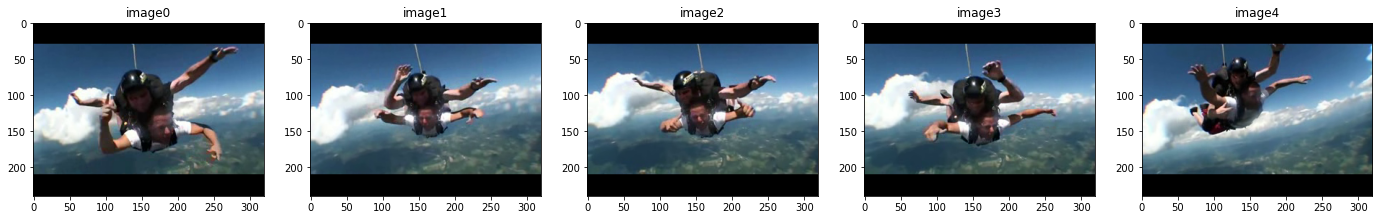

In [71]:
if __name__ == "__main__":
  dataset_path = '/content/drive/MyDrive/zebraCat/ToyDataset.csv'
  dataset = VideoFrames(dataset_path)
  sample_frames, caption = dataset[0]

  cols = dataset.num_frames
  figure, ax = plt.subplots(nrows=1, ncols=cols, figsize=(24,6))
  sample_frames = np.array(sample_frames)
  for i in range(cols):
    image = sample_frames[:,i,:,:]
    image = image.transpose(1,2,0)
    image = (image+1)*127.5
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = image.astype('uint8')
    ax[i].imshow(image)
    ax[i].set_title(f'image{i}')
    
  print(caption)

In [74]:
class MyCollate:
  def __init__(self,pad_idx):
    self.pad_idx = pad_idx
  def __call__(self,batch):
    frames = [item[0].unsqueeze(0) for item in batch]
    frames = torch.cat(frames,dim=0)
    captions = [item[1] for item in batch]
    captions = pad_sequence(captions, batch_first=False, padding_value=self.pad_idx) #stacks a list of Tensors along a new dimension, and pads them to equal length.

    return frames,captions

In [77]:
if __name__ == "__main__":
  dataset_path = '/content/drive/MyDrive/zebraCat/ToyDataset.csv'
  dataset = VideoFrames(dataset_path)
  data_loader  = torch.utils.data.DataLoader(dataset, batch_size=2, collate_fn=MyCollate(pad_idx=5))
  for iter,data in enumerate(data_loader):
    print('iteration:',iter)
    frames = data[0]
    caption = data[1]
    print(frames.shape)
    print(caption.shape)

iteration: 0
torch.Size([2, 3, 5, 240, 320])
torch.Size([8, 2])
iteration: 1
torch.Size([2, 3, 5, 240, 320])
torch.Size([12, 2])
iteration: 2
torch.Size([1, 3, 5, 240, 320])
torch.Size([8, 1])
